 # Chicago Traffic
 by: **Marco Illemann, Rasmus Liebst and Robert Karlsson**

 # 1. Motivation
 In this project, we investigate the traffic of the City of Chicago as a case study of a busy urban environment.
 With its population of approximately 2.7 million it is the third-most-populous city in the United States.
 Daily life in Chicago thus entails millions of people participating in the city's traffic.
 We will have a main focus on temporal patterns of traffic in the project.

 Two data sets are used for this project:
 * [Traffic Crashes - Crashes](https://data.cityofchicago.org/Transportation/Traffic-Crashes-Crashes/85ca-t3if)
 * [Chicago Traffic Tracker - Historical Congestion Estimates by Region - 2018-Current](https://data.cityofchicago.org/dataset/Chicago-Traffic-Tracker-Historical-Congestion-Esti/kf7e-cur8)

 In the following, these are referred to as the *Crashes* and *Congestion* data sets, respectively.
 Both sets are freely available via [Chicago Data Portal](https://data.cityofchicago.org).

 The Crashes data set contains location as well as a multitude of meta data on each police registered traffic crash within the City of Chicago limits and under the jurisdiction of Chicago Police Department.

 The Congestion data set contains information about the congestion of the streets.
 Congestion is estimated by probing GPS traces from the public transportation buses, yielding regional average speeds of
 buses with 10 minutes intervals. The congestion data set features a division of Chicago into 29 regions that covers the city (except O’Hare airport area).
 With comparable traffic patterns, a region is comprised of two or three community areas.

 The combination of theses two data sets allows for relating each crash to one of the 29 defined regions of the City of
 Chicago, as well as the estimated level of congestion at the time of the crash.

 Through careful analysis of the data, the goal is to elicit interesting findings about the traffic patterns of the City of Chicago and convey them in an intuitive manner
 to educate, non-scientific readers.

 # 2. Basic Stats

 ### Data Cleaning
 The Crashes data set has 49 attributes and—at the time of writing—404000 data objects.
  In the format of a CSV file it takes up 222 MB of storage.
 Gathering of the data began in 2015 and has since been updated daily.
 It is thus a fairly large data set and we early on in the process deemed necessary to narrow down in "scope" - both in terms of time and attributes.
 For this project, traffic is analyzed over the course of a full year to be able to analyze the temporal variations throughout a full year.
 Thus, only crashes that took place during 2019 (the most recent full year) are considered:

In [1]:
import datetime
import math

import folium
import numpy as np
import pandas as pd
from IPython.display import Image, display, HTML
from bokeh.io import output_file, show
from bokeh.palettes import Category20, Category20b
from bokeh.plotting import figure

import folium
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import Image
from bokeh.io import output_file, show, output_notebook
from bokeh.models import FactorRange, Legend, LinearAxis, Range1d
from bokeh.palettes import Category20, Category20b, Reds
from bokeh.plotting import figure
from bokeh.transform import dodge
from folium import plugins
from folium.plugins import HeatMap

In [2]:
dev = False

In [3]:
output_notebook()

Loading BokehJS ...

In [4]:
# Load the Crashes data set:
if dev:
    data = pd.read_csv('../data/Traffic_Crashes_-_Crashes.csv')

    # Filter to only consider rows where CRASH_DATE is within the year of 2019
    is_after_start_date = datetime.date(
        2019, 1, 1) <= pd.to_datetime(data['CRASH_DATE']).dt.date
    is_before_end_date = pd.to_datetime(
        data['CRASH_DATE']).dt.date < datetime.date(2020, 1, 1)


 As the location of each crash plays an important role in this project,
 data objects with empty values for location are removed:


In [5]:
# Filter out rows where LOCATION is nan
if dev:
    data = data.dropna(subset=['LOCATION'])



 Several attributes were removed; either because they were deemed irrelevant or because
 contained too many empty values:


In [6]:
if dev:
    # Remove unused columns
    filter_columns = ['STATEMENTS_TAKEN_I', 'CRASH_DATE_EST_I', 'PHOTOS_TAKEN_I', 'WORKERS_PRESENT_I', 'WORK_ZONE_I',
                      'WORK_ZONE_TYPE', 'DATE_POLICE_NOTIFIED', 'REPORT_TYPE', 'LANE_CNT']

    data = data.drop(columns=filter_columns)

    # Create a new .csv file that only contains data from 2019
    data.loc[is_after_start_date & is_before_end_date].to_csv(
        '../data/crashes_2019.csv', index=False)
    data = None


 The Congestion data set has 17 attributes and—at the time of writing—3.07 million data objects.
 In the format of a CSV file it takes up 669 MB of storage.
 Gathering of data began in 2018 and has since been updated every 10 minutes—hence the large size of the set.
 As with the Crashes data set, only data for 2019 is considered:


In [7]:
if dev:
    # Load the Congestion data set:
    data = pd.read_csv(
        '../data/Chicago_Traffic_Tracker_-_Historical_Congestion_Estimates_by_Region_-_2018-Current.csv')

    # Filter to only consider rows where TIME is within the year of 2019
    is_after_start_date = datetime.date(
        2019, 1, 1) <= pd.to_datetime(data['TIME']).dt.date
    is_before_end_date = pd.to_datetime(
        data['TIME']).dt.date < datetime.date(2020, 1, 1)

    # Create a new .csv file that only contains data from 2019
    data.loc[is_after_start_date & is_before_end_date].to_csv(
        '../data/congestion_2019.csv', index=False)
    data = None


 With the two data sets cleaned and filtered to only contain data for 2019,
 their combined size is now reduced to 377 MB.


 ### Preprocessing

 The Congestion data set holds information on estimated congestion at 10 minute intervals for each region of the City of
 Chicago.
 A region is defined in terms of an ID, a name as well as long- and latitudes defining its bounds.
 Given the long- and latitude of crash, it is possible to find the region within which the crash took place.
 The found region ID is then added as an attribute to the Crashes data set for each crash.


In [8]:
if dev:
    # Load the Congestion 2019 data set
    congestion_data = pd.read_csv('../data/congestion_2019.csv')

    # Extract a list of unique region IDs
    region_ids = congestion_data['REGION_ID'].unique()

    # Create a dictionary of regions with ID and corner locations

    regions = []
    for region_id in region_ids:
        region_specimen = congestion_data.loc[congestion_data['REGION_ID']
                                              == region_id].iloc[0]
        nw_loc = (region_specimen['WEST'], region_specimen['NORTH'])
        se_loc = (region_specimen['EAST'], region_specimen['SOUTH'])
        regions.append({
            'id': region_id,
            'nw': nw_loc,
            'se': se_loc,
        })

    def is_crash_in_region(crash_loc, region_nw_loc, region_se_loc):
        """Given the location of a crash and the corners of a region, return true if the crash took place within the region, false otherwise."""
        foo = min(region_nw_loc[0], region_se_loc[0]) < crash_loc[0] < max(
            region_nw_loc[0], region_se_loc[0])
        bar = min(region_nw_loc[1], region_se_loc[1]) < crash_loc[1] < max(
            region_nw_loc[1], region_se_loc[1])
        return foo and bar

    # Load the Crashes 2019 data set
    crashes_data = pd.read_csv('../data/crashes_2019.csv')
    N = len(crashes_data)

    # Create a list with a region ID for each row (defaulting to -1)

    crashes_region_ids = np.full(N, -1)
    for idx, row in crashes_data.iterrows():
        loc = (row['LONGITUDE'], row['LATITUDE'])
        for region in regions:
            if is_crash_in_region(loc, region['nw'], region['se']):
                crashes_region_ids[idx] = region['id']
                break

    # Add a REGION_ID attribute to the data set
    crashes_data['REGION_ID'] = crashes_region_ids

    # Write a new version of the data set to disk
    crashes_data.to_csv('../data/crashes_2019_regions.csv', index=False)


 ### Basic statistics


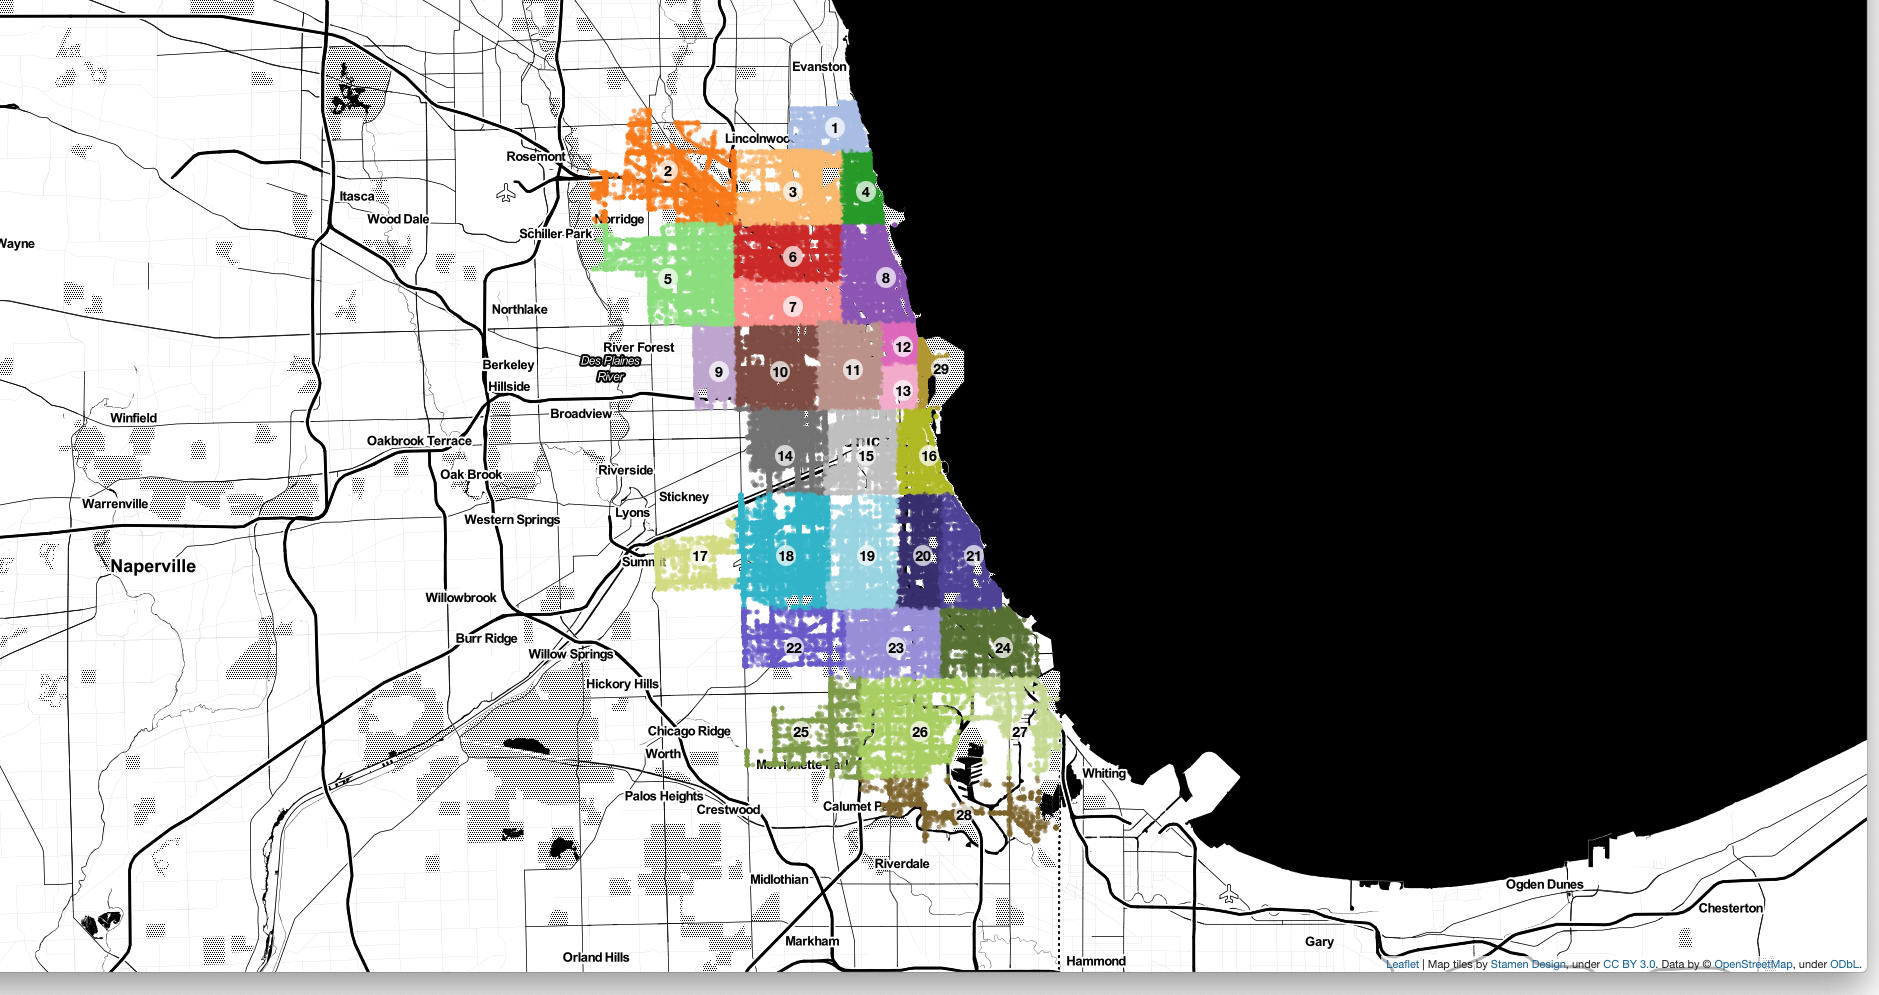

In [9]:
if dev:
    crashes = pd.read_csv("../data/crashes_2019_regions.csv")
    regions = pd.read_csv("../data/congestion_2019.csv")

    cols = ['LATITUDE', 'LONGITUDE', 'REGION_ID']
    locations = crashes.loc[:, cols]

    # Calculate center for each region
    region_idx = np.sort(regions.REGION_ID.unique())
    centers = []
    for i in region_idx:
        # First row for the region
        regions[(regions.REGION_ID == 2)].iloc[0]
        north = regions[(regions.REGION_ID == i)].iloc[0].NORTH
        south = regions[(regions.REGION_ID == i)].iloc[0].SOUTH
        east = regions[(regions.REGION_ID == i)].iloc[0].EAST
        west = regions[(regions.REGION_ID == i)].iloc[0].WEST
        centers.append({
            'id': i,
            'center_x': (east + west)/2,
            'center_y': (north+south)/2
        })
    # idx = np.arange(0, 255, int(256 / 29))
    # colors = np.array(Turbo256)[idx]
    colors = np.append(Category20[20], Category20b[10])
    lon = -87.6298
    lat = 41.8281
    CHI_map = folium.Map([lat, lon], tiles="Stamen Toner", zoom_start=10.5)

    for i, row in locations.iterrows():
        # TODO: Only for hand-in..
        break
        region = row.REGION_ID
        if region == -1:
            continue

        loc = (row['LATITUDE'], row['LONGITUDE'])
        folium.CircleMarker((loc[0], loc[1]),
                            radius=.15,
                            fill=True,
                            opacity=.6,
                            color=colors[int(row.REGION_ID)]).add_to(CHI_map)

    for region in centers:
        folium.Marker(location=(region["center_y"], region["center_x"]),
                      icon=folium.DivIcon(
            html=f"""<div style="background-color:rgba(255,255,255,.7); border-radius:50%; width:20px">
                                        <div style="color:black; font-size:14px; width:fit-content; margin:auto; font-weight: 600">{region["id"]}</div>
                                    </div>""")
        ).add_to(CHI_map)
    # CHI_map.save("../web/folium/chi_regions.html")
Image('../web/folium/pngs/regions.png')

 As described in the *Motivation* section, Chicago is divided into 29 regions in order to estimate traffic congestion around the city.
 To visualize this partition, all crashes has been plotted with a unique color for each region.
 To ease the relation between future findings and location of the regions, the unique IDs are added to the figure.

In [10]:
if dev:
    crashes = pd.read_csv("../data/crashes_2019_regions.csv")
    # BASIC PRIMARY CAUSE PLOT
    output_file("../web/bokeh/primary_cause_bar_chart.html")

    crashes_primary = crashes[(crashes['PRIM_CONTRIBUTORY_CAUSE'] != 'UNABLE TO DETERMINE')
                              & (crashes['PRIM_CONTRIBUTORY_CAUSE'] != 'NOT APPLICABLE')]
    cp = crashes[(crashes['PRIM_CONTRIBUTORY_CAUSE'] != 'UNABLE TO DETERMINE')
                 & (crashes['PRIM_CONTRIBUTORY_CAUSE'] != 'NOT APPLICABLE')].PRIM_CONTRIBUTORY_CAUSE.unique()
    counts = None
    counts = crashes_primary['PRIM_CONTRIBUTORY_CAUSE'].value_counts(
    ).sort_values()

    TOOLTIPS = [
        ("Number of crashes", "@top")
    ]

    p = figure(x_range=counts.index.values,
               plot_height=1050,
               plot_width=1050,
               toolbar_location=None,
               tools='',
               tooltips=TOOLTIPS,
               y_axis_label='Number of Crashes',
               min_border_right=250)
    # frame_width=1600)
    # y_axis_type="log")

    p.vbar(x=counts.index.values, top=counts, width=0.5, fill_alpha=0.25,
           fill_color='#000000', line_color='#000000', bottom=0.01)
    p.xgrid.grid_line_color = None
    p.xaxis.major_label_orientation = -0.4 * math.pi/2
    p.y_range.start = 0
    #plots = bokeh.gridplot([[p]], sizing_mode='scale_width')
    show(p)
display(HTML("<iframe src='https://chicago-traffic.netlify.app/bokeh/primary_cause_bar_chart.html' height='750' width='1000'></iframe>"))

 One interesting attribute of the Crashes data set is the _primary contributory cause_ (PCC).
 The figure above shows the distribution of PCCs over all crashes of 2019.
 It is seen that the two most common PCCs are _failing to yield right-of-way_ and _following too closely_.
 The large range in number of crashes in the figure makes it difficult to read the values of the left most part.
 The tooltip functionality of Bokeh is of no use because the bars are so small.
 This can be remedied by using a log scale for the y-axis:

In [11]:
# BASIC PRIMARY CAUSE PLOT (LOG Y-AXIS)
if dev:
    output_file("../web/bokeh/primary_cause_bar_chart_log.html")

    crashes_primary = crashes[(crashes['PRIM_CONTRIBUTORY_CAUSE'] != 'UNABLE TO DETERMINE')
                              & (crashes['PRIM_CONTRIBUTORY_CAUSE'] != 'NOT APPLICABLE')]
    cp = crashes[(crashes['PRIM_CONTRIBUTORY_CAUSE'] != 'UNABLE TO DETERMINE')
                 & (crashes['PRIM_CONTRIBUTORY_CAUSE'] != 'NOT APPLICABLE')].PRIM_CONTRIBUTORY_CAUSE.unique()
    counts = None
    counts = crashes_primary['PRIM_CONTRIBUTORY_CAUSE'].value_counts(
    ).sort_values()

    TOOLTIPS = [
        ("Number of crashes", "@top")
    ]

    p = figure(x_range=counts.index.values,
               plot_height=1050,
               plot_width=1050,
               toolbar_location=None,
               tools='',
               tooltips=TOOLTIPS,
               y_axis_label='Number of Crashes',
               y_axis_type="log",
               min_border_right=250)

    p.vbar(x=counts.index.values, top=counts, width=0.5, fill_alpha=0.25,
           fill_color='#000000', line_color='#000000', bottom=0.01)
    p.xgrid.grid_line_color = None
    p.xaxis.major_label_orientation = -0.4 * math.pi/2
    p.y_range.start = 10**(0)
    show(p)
display(HTML("<iframe src='https://chicago-traffic.netlify.app/bokeh/primary_cause_bar_chart_log.html' height='750' width='1000'></iframe>"))

 The figure above shows the same data as the previous figure, but with a log-10 scale for the y-axis resulting in
 in a more readable chart. Now, all the bars are tall enough to afford the tooltip functionality of Bokeh—hovering the
 cursor over the bar for _Motorcycle advancing legally on red light_ reveals a total number of crashes of 6.

In [12]:
# BASIC REGION CRASH BAR CHART
if dev:
    output_file("../web/bokeh/region_bar_chart.html")

    congestion = pd.read_csv("../data/congestion_2019.csv")
    crashes = crashes[crashes['REGION_ID'] != -1]

    region_id_region = congestion.groupby(
        ['REGION_ID', 'REGION']).size().index.values
    region_dict = dict(region_id_region)
    crashes['REGION_PRETTY'] = [str(x) + ": " + region_dict.get(x)
                                for x in crashes['REGION_ID']]
    congestion['REGION_PRETTY'] = [
        str(x) + ": " + region_dict.get(x) for x in congestion['REGION_ID']]

    counts = None
    counts = crashes.groupby('REGION_PRETTY').size().sort_values()
    cx = counts.index.values.astype(str)

    TOOLTIPS = [
        ("Number of crashes", "@top")
    ]

    p = figure(x_range=cx,
               plot_height=500,
               plot_width=700,
               toolbar_location=None,
               tools='',
               tooltips=TOOLTIPS,
               y_axis_label='Number of Crashes',
               x_axis_label='Region',
               min_border_right=150)

    p.vbar(x=cx, top=counts, width=0.5, fill_alpha=0.25,
           fill_color='#000000', line_color='#000000'),  # bottom=0.01)
    p.xgrid.grid_line_color = None
    p.y_range.start = 0
    p.xaxis.major_label_orientation = -0.4 * math.pi/2
    #p.xaxis.ticker = list(range(1, 30))
    show(p)
display(HTML("<iframe src='https://chicago-traffic.netlify.app/bokeh/region_bar_chart.html' height='750' width='1000'></iframe>"))

 The figure above shows the distribution of crashes over all 29 regions for 2019.
 It is seen that the region _South West Side_ (with ID 18) is suffering the most from crashes,
 whereas _Riverdale-Hegewisch_ (with ID 28) is the region with the least crashes.

In [13]:
# BASIC REGION AVG SPEED BAR CHART
if dev:
    output_file("../web/bokeh/region_avg_speed_bar_chart.html")

    congestion = pd.read_csv("../data/congestion_2019.csv")

    region_id_region = congestion.groupby(
        ['REGION_ID', 'REGION']).size().index.values
    region_dict = dict(region_id_region)
    crashes['REGION_PRETTY'] = [str(x) + ": " + region_dict.get(x)
                                for x in crashes['REGION_ID']]
    congestion['REGION_PRETTY'] = [
        str(x) + ": " + region_dict.get(x) for x in congestion['REGION_ID']]

    avg_speed = congestion.groupby('REGION_PRETTY')[
        'SPEED'].mean().sort_values()
    counts = None
    counts = avg_speed
    cx = counts.index.values.astype(str)

    TOOLTIPS = [
        ("Average speed (mph)", "@top")
    ]
    # np.sort(congestion['REGION_ID'].unique, axis=None
    p = figure(  # x_range=(1, 29),
        # FactorRange(factors=str(counts.index.values)),
        # x_range=counts.index.values.astype(str),
        x_range=cx,
        plot_height=500,
        plot_width=700,
        toolbar_location=None,
        tools='',
        tooltips=TOOLTIPS,
        y_axis_label='Average Speed (mph)',
        x_axis_label='Region',
        min_border_right=150)

    p.vbar(x=cx, top=counts, width=0.5, fill_alpha=0.25,
           fill_color='#000000', line_color='#000000'),  # bottom=0.01)
    p.xgrid.grid_line_color = None
    p.y_range.start = 15
    p.xaxis.major_label_orientation = -0.4 * math.pi/2
    #p.xaxis.ticker = list(range(1, 30))
    show(p)
display(HTML("<iframe src='https://chicago-traffic.netlify.app/bokeh/region_avg_speed_bar_chart.html' height='750' width='1000'></iframe>"))

 The figure above shows the average speed for public transportation buses for all 29 regions for 2019.
 It is seen that buses servicing the region _Chicago Loop_ (with ID 13) has the lowest average speed,
 whereas buses in the region _Washington Hts-Roseland-Pullman_ (with ID 26) has the highest average speed.
 The average speed of the buses is considered a measure for the level of traffic congestion across the regions.
 It is hypothesized that the level of congestion is correlated to the amount of traffic on the
 streets—the lower the average speed, the more vehicles on the streets.

 # 3. Data Analysis
 In this section, we dive further into the data analysis we got an initial overview of in the previous section.
 First, we will look at the temporality of crashes in Chicago. In the latter half, we will look further into the locations
 of crashes (also with some temporal perspectives) to understand where different types of crashes occurs.

In [14]:
if dev:
    crashes = pd.read_csv("../data/crashes_2019_regions.csv")

In [15]:
#
# ### Monthly and Weekly Temporal Patterns
#

 ##############################################################################################################
 ### CRASH COUNT MONTHS PLOT

In [16]:
if dev:
    output_file("../web/bokeh/months_barchart.html")
    x = ['January', 'February', 'March', 'April', 'May', 'June', 'July',
         'August', 'September', 'October', 'November', 'December']
    counts = crashes['CRASH_MONTH'].value_counts().sort_index()

    TOOLTIPS = [
        #("Hour", "$index"),
        #("Day", "@x"),
        ("Number of crashes", "@top")
    ]

    p = figure(x_range=x,
               plot_height=450,
               plot_width=800,
               title="Monthly Crash Distribution",
               toolbar_location=None,
               tools='',
               tooltips=TOOLTIPS,
               y_axis_label='Number of Crashes',
               x_axis_label='Month')

    p.vbar(x=x, top=counts, width=0.5, fill_alpha=0.25,
           fill_color='#000000', line_color='#000000')

    p.xgrid.grid_line_color = None
    p.y_range.start = 0

    show(p)
display(HTML("<iframe src='https://chicago-traffic.netlify.app/bokeh/months_barchart.html' height='750' width='1000'></iframe>"))

 To start off our temporal analysis, we look at the distribution of crashes over the months of year of 2019 as seen in the bar chart above.
 Interestingly, we see that the summer months May till July has the highest number of crashes. May has the most crashes
 with 10,584. The lowest was seen in February with 8,542 crashes. Our hypothesis prior to plotting was that the winter months had more crashes, but this plot
 proved us otherwise. One explanation could be that the summer months see more traffic as it also tourist season.

 ##############################################################################################################
 ### CRASH COUNT DAYS PLOT

In [17]:
if dev:
    output_file("../web/bokeh/days_barchart.html")

    weekdays = ['Monday', 'Tuesday', 'Wednesday',
                'Thursday', 'Friday', 'Saturday', 'Sunday']
    counts = None
    counts = crashes['CRASH_DAY_OF_WEEK'].value_counts().sort_index()

    TOOLTIPS = [
        #("Hour", "$index"),
        #("Day", "@x"),
        ("Number of crashes", "@top")
    ]

    p = figure(x_range=weekdays,
               plot_height=450,
               toolbar_location=None,
               tools='',
               tooltips=TOOLTIPS,
               y_axis_label='Number of Crashes',
               x_axis_label='Day of the Week')

    p.vbar(x=weekdays, top=counts, width=0.5, fill_alpha=0.25,
           fill_color='#000000', line_color='#000000')

    p.xgrid.grid_line_color = None
    p.y_range.start = 0

    show(p)
display(HTML("<iframe src='https://chicago-traffic.netlify.app/bokeh/days_barchart.html' height='750' width='1000'></iframe>"))

 Next up we look at the distribution of crashes throughout the days of the week as seen in the bar chart above. We
 can see that the weekend has the most crashes peaking Saturday with 18,480 crashes. Monday has the lowest with 14,027 crashes.
 This could be due to more traffic occurring during the weekend.

In [18]:
# > TODO: Heat map of weekly pattern
#
# ### Daily Temporal Patterns
#

 ##############################################################################################################
 ### HOUR PLOT HISTOGRAM

In [19]:
if dev:
    output_file("../web/bokeh/hours_barchart.html")

    hours = pd.DataFrame({'CRASH_HOUR': np.arange(0, 24)})

    x = np.sort(crashes['CRASH_HOUR'].unique()).tolist()
    xx = x.copy()
    xx.append(24)
    counts = crashes['CRASH_HOUR'].value_counts().sort_index()

    TOOLTIPS = [
        ("Crashes", "@top"),
    ]

    p = figure(plot_height=450,
               plot_width=800,
               title="Hourly Crash Distribution",
               toolbar_location=None,
               tools='',
               tooltips=TOOLTIPS,
               y_axis_label='Number of Crashes',
               x_axis_label='Hour')

    p.quad(top=counts, left=xx[:-1], right=xx[1:], width=0.5,
           fill_color='#000000', line_color='#000000', fill_alpha=0.25)

    p.xgrid.grid_line_color = None
    p.y_range.start = 0
    p.xaxis.ticker = list(range(0, 24))

    show(p)
display(HTML("<iframe src='https://chicago-traffic.netlify.app/bokeh/hours_barchart.html' height='750' width='1000'></iframe>"))

 In the above plot, we look at the 24 hours of the day. Here we can clearly see that amount of crashes follow the initution of when
 there is peak traffic in a city; around commute time to and from work. We clearly see a spike around 8-9 am (to work) and then again
 at 15-19 pm (home from work). From there on, we see a decreasing decline of crashes from 18 pm till 5 am.

 ##############################################################################################################
 ### HOUR PLOT HISTOGRAM WITH AVERAGE SPEED TREND LINE

In [20]:
if dev:
    congestion = pd.read_csv("../data/congestion_2019.csv")
    output_file("../web/bokeh/hours_congestion_barchart.html")

    congestion = congestion[congestion['SPEED'] > 0.0]
    regions_congestion = congestion.groupby(
        ['REGION_ID', 'HOUR'])['SPEED'].mean()
    hour_congestion = congestion.groupby('HOUR')['SPEED'].mean()

    hours = pd.DataFrame({'CRASH_HOUR': np.arange(0, 24)})

    x = np.sort(crashes['CRASH_HOUR'].unique()).tolist()
    xx = x.copy()
    xx.append(24)
    counts = crashes['CRASH_HOUR'].value_counts().sort_index()

    # TOOLTIPS = [
    #    ("Crashes", "@top"),
    # ]

    p = figure(  # x_range=(-0.5,23.5),
        plot_height=450,
        plot_width=800,
        title="Hourly Crash Distribution",
        toolbar_location=None,
        tools='',
        # tooltips=TOOLTIPS,
        y_axis_label='Number of Crashes',
        x_axis_label='Hour')

    #p.yaxis.axis_line_color = "navy"
    # p.vbar(x=x, top=counts, width=0.5, fill_alpha=0.25, fill_color='#000000', line_color='#000000')
    p.quad(top=counts, left=xx[:-1], right=xx[1:], width=0.5,
           fill_color='#000000', line_color='#000000', fill_alpha=0.25)

    p.extra_y_ranges = {'SPEED': Range1d(
        start=(hour_congestion.min()-0.25), end=(hour_congestion.max())+0.25)}
    p.add_layout(LinearAxis(y_range_name='SPEED',
                            axis_label="Average speed (mph)", axis_line_color='red'), 'right')

    extra_value_y = pd.Series([hour_congestion[0]], index=[24])
    hour_congestion = hour_congestion.append(extra_value_y)
    p.line(xx, hour_congestion.array, line_width=1,
           y_range_name='SPEED', line_color="red")

    p.xgrid.grid_line_color = None
    p.y_range.start = 0
    p.xaxis.ticker = list(range(0, 24))

    show(p)
display(HTML("<iframe src='https://chicago-traffic.netlify.app/bokeh/hours_congestion_barchart.html' height='750' width='1000'></iframe>"))

 To further understand the crash distribution of the day, here we see the same histogram as previously, but now with a trend line showing the
 average speed in mph. It is clear that the two move inversely; when the crashes are low, average speed is high and vice versa. This verifies
 the intuition that less average speed means cluttering which also means more traffic which finally means more crashes.

 ##############################################################################################################
 ### CRASH COUNT VS. AVERAGE SPEED SCATTERPLOT

In [21]:
if dev:
    # TODO: Don't use hardcoded dicts
    region_crashes_tally = {3: 5199, 15: 4024, 18: 7739, 19: 4021, 2: 4114, 8: 6159, 26: 3923, 6: 4895, 7: 4922, 20: 3413,
                            13: 5461, 22: 2267, 10: 6406, 5: 6591, 11: 6782, 4: 2940, 14: 4409, 16: 2847, 28: 1049, 9: 2873,
                            23: 4908, 12: 4140, 21: 3190, 24: 3625, 1: 2592, 17: 1288, 27: 1477, 25: 1832, 29: 2407,
                            -1: 801}

    region_speed_means = {1: 20.577022889511255, 2: 26.68329213080924, 6: 22.633488102758474, 21: 23.674691823369628,
                          7: 21.460690040008423, 18: 25.10555749752574, 29: 19.161841900229525, 22: 27.68232664406494,
                          10: 23.731599250384285, 14: 24.040862286797218, 3: 23.235282065320387, 23: 24.224279517361918,
                          28: 20.995748278548717, 13: 18.773307222573173, 8: 20.809373144385255, 4: 20.18918570616353,
                          19: 26.006200593821728, 17: 24.532245198787063, 12: 19.132034112444728, 27: 28.521725241634904,
                          24: 24.968908799932617, 9: 22.66006338042998, 20: 25.892239044831435, 5: 22.866837583440375,
                          16: 24.206990186994606, 11: 22.74667487892188, 25: 25.541196908757822, 26: 28.672279475246896,
                          15: 25.74476016003369}

    x = np.zeros(29)
    for key, val in region_crashes_tally.items():
        if key == -1:
            break
        x[key - 1] = val

    y = np.zeros(29)
    for key, val in region_speed_means.items():
        y[key - 1] = val

    TOOLTIPS = [
        ("Region ID", "$index"),
        ("Number of crashes", "@x"),
        ("Avg. speed (mph)", "@y{(0.0)}"),
    ]

    # create a new plot with a title and axis labels
    p = figure(
        x_axis_label='Number of Crashes',
        y_axis_label='Avg. Speed',
        toolbar_location=None,
        tools='',
        tooltips=TOOLTIPS,
        sizing_mode='stretch_both',
    )

    p.circle(x, y, size=18, fill_color="black",
             fill_alpha=0.25, line_color="black")

    # Output to static HTML file
    output_file("../web/bokeh/crash_count_vs_avg_speed.html")
    show(p)
display(HTML("<iframe src='https://chicago-traffic.netlify.app/bokeh/crash_count_vs_avg_speed.html' height='750' width='1000'></iframe>"))

 From the previous plot, we got the hypothesis that the regions that generally had lower average speed would have more
 crashes. From the scatter plot above, however, we see there is no evident tendency in region average speed and amount of crashes.

 ##############################################################################################################
 ### PRIMARY CAUSE BOKEH

In [22]:
if dev:
    crashes = pd.read_csv("../data/crashes_2019_regions.csv")
    output_file("../web/bokeh/primary_cause.html")
    # Filtering the primary causes 'UNABLE TO DETERMINE' and 'NOT APPLICABLE' as we deem this irrelevant for the purpose of the plot
    crashes_primary = crashes[(crashes['PRIM_CONTRIBUTORY_CAUSE'] != 'UNABLE TO DETERMINE')
                              & (crashes['PRIM_CONTRIBUTORY_CAUSE'] != 'NOT APPLICABLE')]
    # Filtering all primary causes that have 150 or less occurences in the 2019 data set.
    cx = crashes_primary.groupby('PRIM_CONTRIBUTORY_CAUSE')
    cx = cx.filter(lambda x: len(x) > 150)
    # crashes_primary.PRIM_CONTRIBUTORY_CAUSE.unique()
    cp = cx.PRIM_CONTRIBUTORY_CAUSE.unique()

    # Counting occurences across the day for each cause
    causes_norm = pd.DataFrame({'CRASH_HOUR': np.arange(1, 25)})
    for cause in cp:
        cause_hist = crashes_primary[crashes_primary['PRIM_CONTRIBUTORY_CAUSE'] == cause].groupby(
            'CRASH_HOUR').size()
        # cause_hist_norm = (cause_hist / cause_hist.sum()) # distribution for a given cause seen only in context of the cause
        causes_norm[cause] = cause_hist
    causes_norm = causes_norm.fillna(0)

    source = causes_norm
    p = figure(x_range=FactorRange(factors=causes_norm.CRASH_HOUR.astype(str)),
               y_axis_type="log",
               title="Crash primary causes throughout the day",
               tools='',
               # tooltips=TOOLTIPS,
               x_axis_label='Hour of the day',
               y_axis_label='Number of crashes',
               plot_width=1700,
               plot_height=725,
               toolbar_location=None,
               sizing_mode='stretch_width')

    bar = {}
    colors = np.append(Category20[20], Category20b[20])
    items = []

    for indx, i in enumerate(cp):
        bar[i] = p.vbar(x=dodge('CRASH_HOUR', -.5, range=p.x_range), top=i, source=source, muted_alpha=0.01, muted=True,
                        width=.5, fill_color=colors[indx], bottom=0.01, alpha=0.6)
        items.append((i, [bar[i]]))
    legend = Legend(items=items)

    p.add_layout(legend, 'right')
    p.legend.label_text_font_size = '8pt'
    p.legend.click_policy = "mute"
    p.y_range.start = 0

    show(p)
display(HTML("<iframe src='https://chicago-traffic.netlify.app/bokeh/primary_cause.html' height='750' width='1000'></iframe>"))

 To further understand what causes the crashes throughout the hours of the day, we have made the interactive bar chart above where
 the reader can enable and disable primary causes for a crash and see the distribution throughout the day. Note that we have filtered
 the causes 'UNABLE TO DETERMINE' as well as 'NOT APPLICABLE' as well as causes that have been registered 150 times or less.
 We have applied a log-scale y-axis as there is a large difference in frequency in the different causes; the two most common being
 'FAILING TO YIELD RIGHT-OF-WAY' and 'FOLLOWING TOO CLOSELY'. However, not all causes follow the general curve of crashes.
 Notably, 'UNDER THE INFLUENCE OF ALCOHOL/DRUGS (USE WHEN ARREST IS EFFECTED)' is practically the opposite peaking around 23-4.
 Also some of the causes that are largely caused by circumstances outside the control of the driver such as
 'VISION OBSCURED (SIGNS, TREE LIMBS, BUILDING, ETC.), 'ROAD CONSTRUCTION/MAINTENANCE' AND 'ROAD ENGINEERING/SURFACE/MARKING DEFECTS'
 see are more uniform frequency throughout the day from 8 am till around 20-22 pm. This implies that drivers are more likely to be
 involved in crashes caused by common human errors in rush hour, likely as they are stressed and slack on safety on account of that.

In [23]:
# ##############################################################################################################

In [24]:
if dev:
    crashes = pd.read_csv("../data/crashes_2019_regions.csv")
    chi_bounding = {
        "lon": -87.6298,
        "lat": 41.8281
    }
    map_location = [chi_bounding['lat'], chi_bounding['lon']]
    map_zoom = 10.5
    # Static heat map crashes
    # TODO: Write text
    CHI_map = folium.Map(
        map_location, tiles="Stamen Toner", zoom_start=map_zoom)
    points = crashes.loc[:, ['LATITUDE', 'LONGITUDE']].dropna()
    lat = points['LATITUDE'].values
    lon = points['LONGITUDE'].values
    heat_data = [[row['LATITUDE'], row['LONGITUDE']]
                 for _, row in points.iterrows()]

    HeatMap(data=heat_data, max_zoom=20, radius=12).add_to(CHI_map)
    CHI_map.save("../web/folium/heat_crashes.html")
    CHI_map
display(HTML("<iframe src='https://chicago-traffic.netlify.app/folium/heat_crashes.html' height='750' width='1000'></iframe>"))

In [25]:
if dev:
    # Heat map over time - Hour
    # TODO: Write text
    CHI_map_time = folium.Map(
        map_location, tiles="Stamen Toner", zoom_start=map_zoom)
    heat_df = crashes.loc[:, ['LATITUDE', 'LONGITUDE', 'CRASH_DATE']].dropna()

    # Create weight column, using date
    heat_df['Weight'] = pd.to_datetime(heat_df['CRASH_DATE']).dt.hour
    heat_df['Weight'] = heat_df['Weight'].astype(float).dropna()

    # List comprehension to make out list of lists
    heat_data = [[[row['LATITUDE'], row['LONGITUDE']] for _, row in heat_df[heat_df['Weight'] == i].iterrows()] for i in
                 range(0, 24)]

    # Plot it on the map
    hm = plugins.HeatMapWithTime(heat_data,
                                 auto_play=False,
                                 radius=4,
                                 position="topright"
                                 )
    hm.add_to(CHI_map_time)
    CHI_map_time.save("../web/folium/heat_crashes_over_time.html")
    CHI_map_time

display(HTML("<iframe src='https://chicago-traffic.netlify.app/folium/heat_crashes_over_time.html' height='750' width='1000'></iframe>"))

In [26]:
if dev:
    # TODO: Insert text
    # Static heat map fatal
    CHI_map = folium.Map(
        map_location, tiles="Stamen Toner", zoom_start=map_zoom)
    incapacitating_injuries = crashes["INJURIES_INCAPACITATING"] > 0
    fatal_injuries = crashes["INJURIES_FATAL"] > 0
    data = crashes[fatal_injuries]
    points = data.loc[:, ['LATITUDE', 'LONGITUDE']].dropna()
    heat_data = [[row['LATITUDE'], row['LONGITUDE']]
                 for _, row in points.iterrows()]

    HeatMap(data=heat_data, max_zoom=15, radius=25).add_to(CHI_map)
    CHI_map.save("../web/folium/heat_fatal.html")
    CHI_map
display(HTML("<iframe src='https://chicago-traffic.netlify.app/folium/heat_fatal.html' height='750' width='1000>"))

In [27]:
if dev:
    # TODO: Insert text
    # Static heat map incapacitating
    CHI_map = folium.Map(
        map_location, tiles="Stamen Toner", zoom_start=map_zoom)
    data = crashes[incapacitating_injuries]
    points = data.loc[:, ['LATITUDE', 'LONGITUDE']].dropna()
    heat_data = [[row['LATITUDE'], row['LONGITUDE']]
                 for _, row in points.iterrows()]

    HeatMap(data=heat_data, max_zoom=15, radius=13).add_to(CHI_map)
    CHI_map.save("../web/folium/heat_incapacitating.html")
    CHI_map
display(HTML("<iframe src='https://chicago-traffic.netlify.app/folium/heat_incapacitating.html' height='750' width='1000'></iframe>"))


In [28]:
if dev:
    # TODO: Insert text
    # Static heat map fatal and incapacitating
    CHI_map = folium.Map(
        map_location, tiles="Stamen Toner", zoom_start=map_zoom)
    incapacitating_injuries = crashes["INJURIES_INCAPACITATING"] > 0
    data = crashes[incapacitating_injuries | fatal_injuries]
    points = data.loc[:, ['LATITUDE', 'LONGITUDE']].dropna()
    heat_data = [[row['LATITUDE'], row['LONGITUDE']]
                 for _, row in points.iterrows()]

    HeatMap(data=heat_data, max_zoom=14, radius=12).add_to(CHI_map)
    CHI_map.save("../web/folium/heat_fatal_and_incapacitating.html")
    CHI_map
display(HTML("<iframe src='https://chicago-traffic.netlify.app/folium/heat_fatal_and_incapacitating.html' height='750' width='1000'></iframe>"))


In [29]:


def calc_color(data):
    color_sq = colors = np.flip(np.array(Reds[6]))

    colors = 'Reds'
    new_data, bins = pd.qcut(data, 6, retbins=True,
                             labels=list(range(6)))
    color_ton = []
    for val in new_data:
        color_ton.append(color_sq[val])
    colors = np.flip(np.array(Reds[6]))
    # sns.palplot(colors, 0.6)
    for i in range(6):
        print("\n"+str(i+1)+': '+str((bins[i])) +
              " => "+str((bins[i+1])), end=" ")
    print("\n\n   1   2   3   4   5   6")
    return color_ton, bins, colors



In [30]:
if dev:
    # Calculating the ratio for fatal and incapacitating crashes
    # TODO: Insert text
    crashes = pd.read_csv("../data/crashes_2019_regions.csv")
    crashes = crashes[crashes['REGION_ID'] != -1]
    region_crashes = crashes.groupby(
        'REGION_ID')['CRASH_DATE'].count().sort_values()
    crashes_fatal_incapacitating = crashes[(crashes['INJURIES_FATAL'] > 0) | (
        crashes['INJURIES_INCAPACITATING'] > 0)]
    region_crashes_fatal_incapacitating = crashes_fatal_incapacitating.groupby(
        'REGION_ID')['CRASH_RECORD_ID'].count().sort_values()
    df = pd.concat(
        [region_crashes, region_crashes_fatal_incapacitating], axis=1)
    df = df.rename(columns={'CRASH_DATE': 'total_crashes',
                            'CRASH_RECORD_ID': 'total_fatal_incap'})
    df['fraction'] = df['total_fatal_incap']/df['total_crashes']
    df = pd.read_csv("../data/fatal_incap_frac.csv", index_col="REGION_ID")
    # Calculating color for the different bins

    regions = pd.read_csv("../data/congestion_2019.csv")
    # Calculate center for each region
    region_idx = np.sort(regions.REGION_ID.unique())
    centers = []
    for i in region_idx:
        # First row for the region
        regions[(regions.REGION_ID == 2)].iloc[0]
        north = regions[(regions.REGION_ID == i)].iloc[0].NORTH
        south = regions[(regions.REGION_ID == i)].iloc[0].SOUTH
        east = regions[(regions.REGION_ID == i)].iloc[0].EAST
        west = regions[(regions.REGION_ID == i)].iloc[0].WEST
        centers.append({
            'id': i,
            'center_x': (east + west)/2,
            'center_y': (north+south)/2
        })
    color_ton, bins, colors = calc_color(data=df.fraction.to_numpy()*100)
    sns.palplot(colors, 0.6)
    cols = ['LATITUDE', 'LONGITUDE', 'REGION_ID']
    locations = crashes.loc[:, cols]
    CHI_map = folium.Map([chi_bounding["lat"], chi_bounding["lon"]],
                         tiles="Stamen Toner", zoom_start=11)

    for i, row in locations.iterrows():
        # TODO: Only for hand-in..
        break
        region = row.REGION_ID
        if region == -1:
            continue

        loc = (row['LATITUDE'], row['LONGITUDE'])
        folium.CircleMarker((loc[0], loc[1]),
                            radius=.15,
                            fill=True,
                            opacity=.6,
                            color=color_ton[int(row.REGION_ID)-1]).add_to(CHI_map)

    for region in centers:
        folium.Marker(location=(region["center_y"], region["center_x"]),
                      icon=folium.DivIcon(
            html=f"""<div style="background-color:rgba(255,255,255,.7); border-radius:50%; width:20px">
                                        <div style="color:black; font-size:14px; width:fit-content; margin:auto; font-weight: 600">{region["id"]}</div>
                                    </div>""")
        ).add_to(CHI_map)
    CHI_map.save("../web/folium/chi_regions_fatal_incap.html")

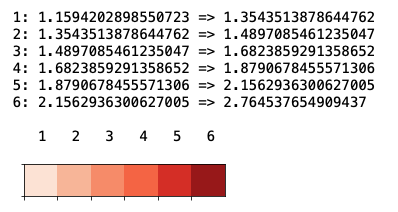

In [31]:
Image("../web/folium/pngs/plplot.png")

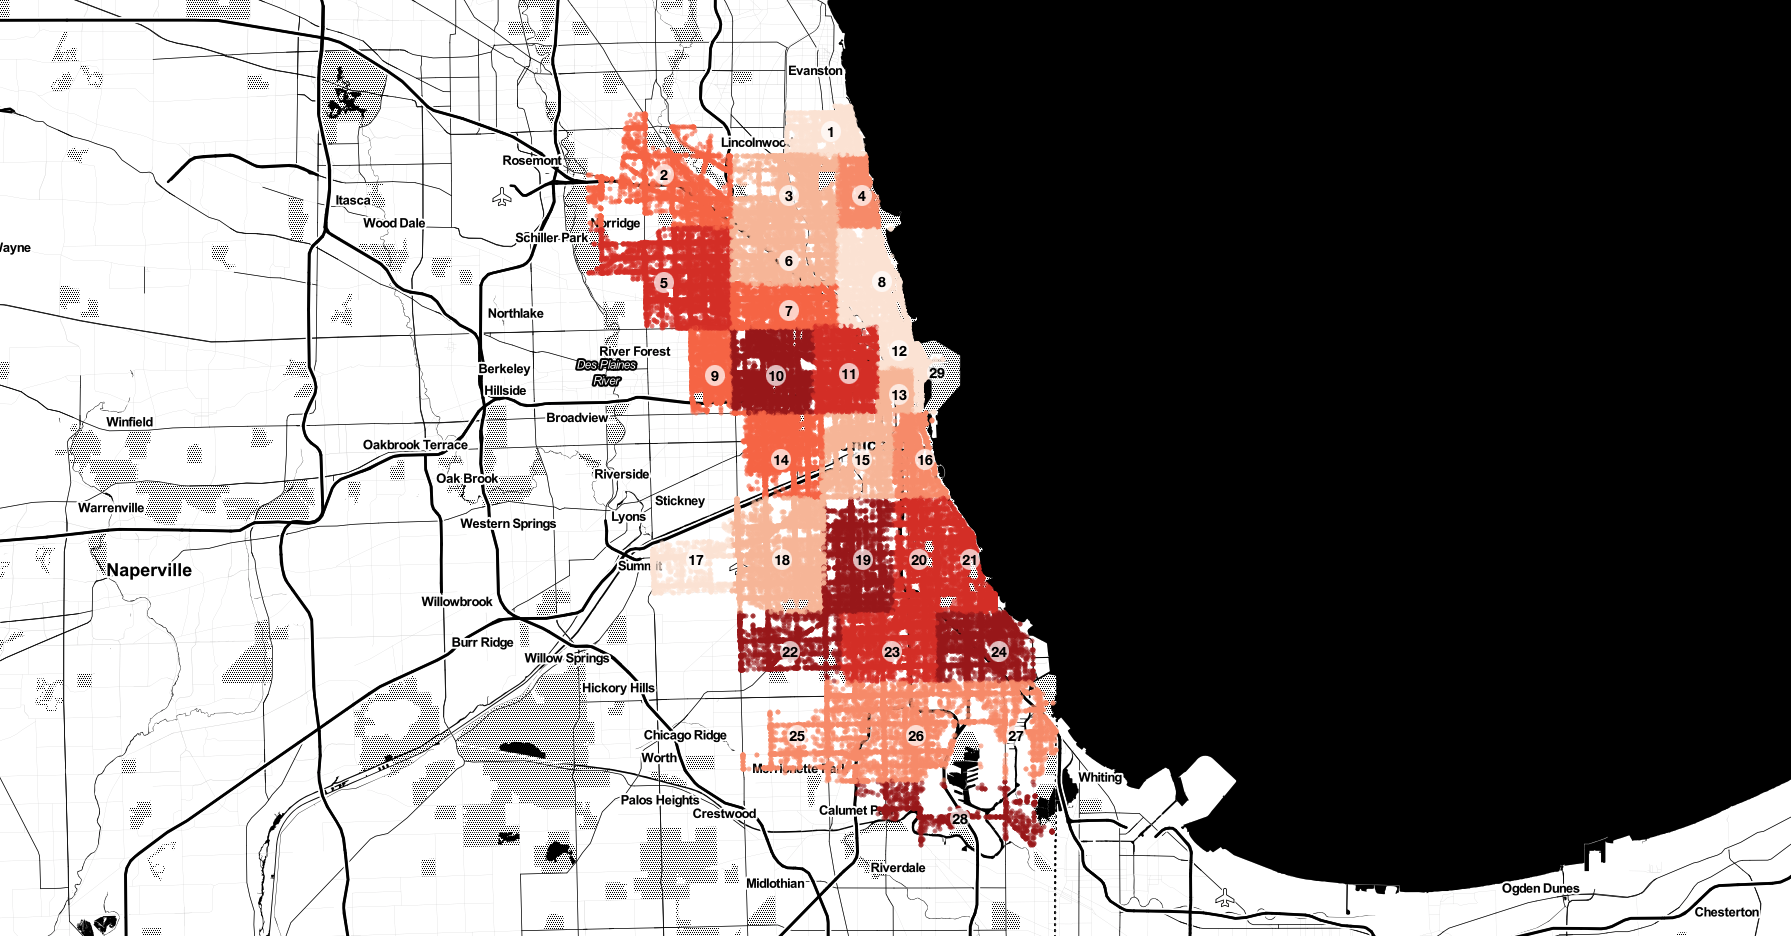

In [32]:
Image("../web/folium/pngs/regions_fatal_incap.png")

 # Genre
 Th website is a single frame _Magazine Style_, where each visualization is embedded in text describing as well as discussing the given visualization.
 In extend to the magazine style, the _Film/Video/Animation_ genre is used for temporal animations enabling visualizations of how crashes occur over time in Chicago, which we consider a subject of interest in our analysis.
 The structure for this project consists of elements from all three categories of _Narrative Structure_ (Figure 7 in [Segal and Heer]).
 The scenes follow a **linear ordering** to ensure that the path viewers take through the visualization is the one prescribed by the authors.
 **Interactivity** – such as _Hover Highlighting_ and _filtering_ – has been utilized for relevant plots in order to engage the user to form their own data diagnostics and pattern discovery.
 Finally **messaging** in the form of _Captions / Headlines_, _Introductory Text_ and **Summary / Synthesis** has been used to communicate observations and commentary to the viewer.
 In terms of Visual Narrative tools (Figure 7 in [Segal and Heer]), highlighting (e.g. feature distinction, motion and zooming) is employ to help direct the viewer’s attention to particular elements of the different scenes.

 # 5. Visualizations
 Almost all charts are bar charts and histograms.
 Bar charts are chosen for their superior readability—they convey categorized quantities concisely.
 Conversely, abominations such as pie and donut charts are _not_ used.
 The goal has been to keep the data–ink ratio [Tufte] high and the color scheme consistent throughout the project.
 In Figure X of Section 3 a twin y-axis chart is used to combine a histogram with a trend line.
 The striking red color of the trend line is also used for coloring the y-axis itself, rendering legends surplus.
 In Figure X of Section 3 a scatter chart is used to investigate the correlation between two attributes.
 For geospatial data, map visualizations are naturally used to convey the locality of crashes as well
 as heat maps showing the concentration of various events. For showing the temporal development of crashes,
 some of the maps are augmented with animations scrubbing through time. Animations are thus an evident choice for temporal visualizations.

 6. Discussion
 What went well

 # 6. Discussion
 # What went well
 The source of visualizations is obviously data. As this assignment basically started in the search of a data set,
 we spend a fair amount of time seeking out a data set of high quality and not just seemed interesting on the surface.
 Eventually, we found the Chicago data sets that seemed promising. This was indeed the case, as we found the data sets
 to be rich and well-groomed with few missing data points and many interesting attributes, more than had time to cover in
 this project. This in turn resulted in a very smooth data cleaning and pre-processing phase that quickly launched us into
 doing actual visualization work. Hence, taking the time to research a promising data was likely a good use of our time on this project.
 For the visualizations, we have had a focus on temporal plots and animations which has shown interesting patterns of traffic
 in different regions of the city through-out the day, month and the grander scheme of a whole year. Furthermore, the focus on
 primary causes for traffic accidents enabling us to see which causes are most common on different times of the day.
 # What is still missing? What could be improved? Why?
 At the outset of this project on of our main goals was to make a quantified assessment of how dangerous
 the streets of Chicago is in terms of its regions and time of day, e.g. to state the probability of a
 crash given location and time.
 By intuition, however, an increase in number of vehicles on the streets leads to an increase in occurrences of crashes.
 This was early on verified by plotting the distribution of crashes throughout the hours of the day.
 This plot revealed spikes around the conventional times for commuting to and from work.
 Simply concluding that these are the most dangerous times to participate in the traffic of Chicago would thus be an erroneous conclusion,
 at least on that basis. To be able to state if one region is generally more dangerous than another,
 one would have to account for the _amount of traffic_ in the regions.
 The ultimate measure for the amount of traffic would be the exact number of vehicles
 passing any given location at any given time. Such data is _not_ available for the City of Chicago, if anywhere.
 Instead, det Congestion data set provides estimates of the traffic congestion in terms of average speed of public
 transportation buses
 a lower average speed indicates a higher level of congestion.
 It is—reasonably—assumed that a higher level of congestion means a higher amount of vehicles on the streets.
 However, the average speed of buses is not only affected by other vehicles taking up space on the streets.
 It is also affected by the number of commuters utilizing them
 more commuters means the buses spend more time at each
 bus stop, pushing the average speed downwards.
 Though not the perfect solution, for this project traffic congestion where used as a measure for the amount of traffic.
 For future work, it could be interesting to access the amount of traffic more precisely, to be able to precisely visualize and assess which
 parts of the city has the highest change of a crash relatively to the amount of traffic. This would ultimately require a different means of
 gathering the data, e.g. via satellite photos.